Pre-algoritmo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import networkx as nx

1. GENERACIÓN MATRIZ M

In [40]:
# 1.1 Leer el archivo CSV sin cabecera
df = pd.read_csv('BACI_HS92_Y2023_V202501.csv', sep=',', header=0,dtype={'k': str})

Contenido de BACI_HS92_Y2010_V202501.csv:

Productos en nomenclatura de 6 dígitos del Sistema Armonizado.
Flujos comerciales a nivel de año - exportador - importador - producto.

t, 1ª columna, año

i, 2ª columna, país exportador

j, 3ª columna, país importador

k, 4ª columna, producto

v, 5ª columna, volumen de producto intercambiado (toneladas métricas)

q, 6ª columna, valor monetario de la transacción (Cientos de dólares)

In [41]:
# 1.2. Agrupar los productos, k, para quedarse con los primeros 4 dígitos.
df['k'] = df['k'].apply(lambda x: str(x)[:4])  # Convertir 'k' a string antes de aplicar el slicing

In [42]:
# 1.3. Crear la matriz usando pivot_table para manejar entradas duplicadas
M = df.pivot_table(index='i', columns='k', values='q', aggfunc='sum')

# Reemplazar NaN por 0 en la matriz resultante
M = M.fillna(0)

# Convertir la matriz M a un DataFrame de pandas para facilitar su manipulación
M = pd.DataFrame(M, index=M.index, columns=M.columns)

Balassa‐type “Revealed Comparative Advantage” (RCA) index

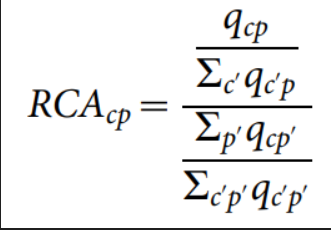

q_cp: quantity (e.g. exports) of product k by country i.

Divided by total quantity of product k across all countries.

Divided by total quantity of all products by country i.

Dividded by total quantity of all products across all countries.

El criterio del filtro no es cantidad exportada, sino el valor que tiene esa cantidad exportada. Si un país regala productos, no afecta en su "economía".

In [43]:
# 1.4. Cálculos para RCA.
# Calcula el RCA_cp para cada elemento de la matriz q y lo sustituye en M.
c, p = M.shape
M_rca = np.zeros((c, p), dtype=float)  # Inicializa la matriz RCA_cp con ceros

In [44]:
suma_total = M.to_numpy().sum()  # Convertir M a un array NumPy para sumar
for i in range(c):
    for j in range(p):
        suma_columna = M.iloc[:, j].sum()
        suma_fila = M.iloc[i, :].sum()
        if suma_columna == 0 or suma_fila == 0:
            M_rca[i, j] = 0  # Evitar división por cero
        else:
            M_rca[i, j] = (M.iloc[i, j] / suma_columna) * (suma_total / suma_fila)

In [45]:
# 1.5. Filtro y creación matriz binaria de M.
# M = np.zeros((c, p), dtype=int)
for i in range(c):
    for j in range(p):
        M.iloc[i, j] = np.where(M_rca[i, j] >= 1, 1, 0)

In [46]:
# Reordenar M
# Convertir M a un DataFrame si es un array de NumPy
if isinstance(M, np.ndarray):
	M = pd.DataFrame(M)

# Ordenar las filas y columnas de M según la suma de sus valores
M = M.loc[M.sum(axis=1).sort_values(ascending=False).index, M.sum(axis=0).sort_values(ascending=False).index]

¿Alguna fila tiene todos sus valores en 0? False
¿Alguna columna tiene todos sus valores en 0? False


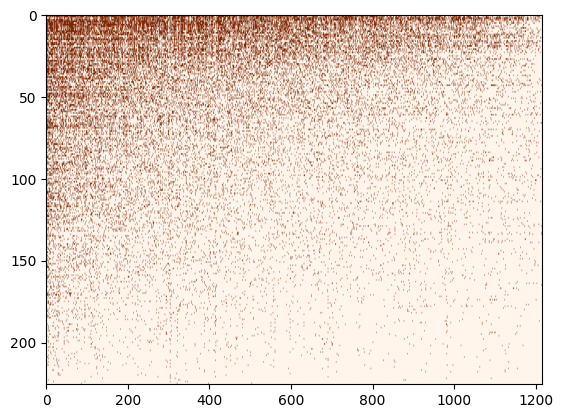

In [47]:
# Eliminación de nodos con grado 0.
# Eliminar filas y columnas de M que sean todo 0
M = M.loc[~(M == 0).all(axis=1), ~(M == 0).all(axis=0)]

# Verificar si alguna fila o columna de M tiene todos sus valores iguales a 0
filas_todo_cero = (M == 0).all(axis=1).any()
columnas_todo_cero = (M == 0).all(axis=0).any()

if filas_todo_cero:
    print("Índice de filas con todos sus valores en 0:", M.index[(M == 0).all(axis=1)].tolist())
if columnas_todo_cero:
    print("Índice de columnas con todos sus valores en 0:", M.columns[(M == 0).all(axis=0)].tolist())

print(f"¿Alguna fila tiene todos sus valores en 0? {filas_todo_cero}")
print(f"¿Alguna columna tiene todos sus valores en 0? {columnas_todo_cero}")

plt.imshow(M, cmap='Oranges', aspect='auto')

ALGORITMO

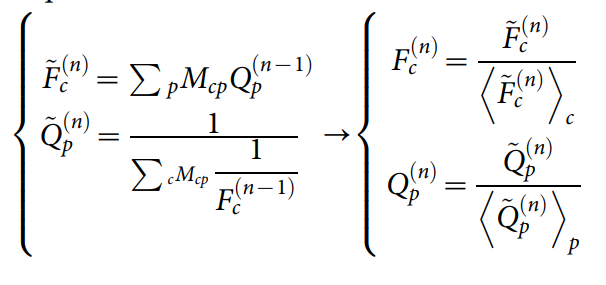

Notación

A^{n}: Vector de la variable A en la iteración n.
Ag^{n}: Vector de la variable no normalizada A en la iteración n. (Variable intemedia de iteración).
B_c^{n}: Componente c de la variable B en la iteración n.

Declaración de variables
F: Vector de la Competitividad normalizada.
Q: Vector de la Complejidad normalizadas.
F_valores: Matriz que guarda los valores de F en cada iteración.
Q_valores: Matriz que guarda los valores de Q en cada iteración.

Consideraciones sobre las Condiciones iniciales:
Para el paso previo de calcular Fg^{n} y Qg^{n}, es necesario haber normalizado F^{n-1} y Q^{n-1}. 
Se toma A^{n} = 0 para el caso de Ag^{n-1} = 0.

Para calcular las variables intermedias Fg^{1} y Qg^{1}, se calculan primero F^{0} y Q^{0}.

In [48]:
c,p = M.shape

#Condiciones iniciales.
Fg = np.ones(c)
Qg = np.ones(p)
# Condiciones iniciales normalizadas.
F = Fg / np.mean(Fg)
Q = Qg / np.mean(Qg)

In [57]:
# Definimos el número de iteraciones.
n = 500
# Definir la transpuesta de la matriz M
M_T = M.T

# Generamos la matriz que va a guardar los valores.
F_valores = np.zeros((n, c))
Q_valores = np.zeros((n, p))

for i in range(n):
    # 1) Cálculo de las variables intermedias:
    Fg = np.dot(M, Q) # donde Fg[c] = \sum_p M_{c,p} * Q[p]
    invF = 1.0 / F # donde invF[c] = 1 / F[c]
    invQ = np.dot(M_T, invF) # donde Qg[p] = \sum_c M_{c,p} * (1/F[c])
    Qg = 1.0 / invQ # np.where(invQ != 0, 1.0 / invQ, 0) # donde Qg[p] = 1 / \sum_c ( M_{c,p} / F_c^{(n-1)} )

    # 2) Normalización y actualización de F y Q para la siguiente iteración.
    F = Fg / np.mean(Fg)
    Q = Qg / np.mean(Qg)

    # 3) Guardar los valores de F y Q en cada iteración para su posterior análisis/representación.
    F_valores[i, :] = F
    Q_valores[i, :] = Q

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13924\3221380476.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


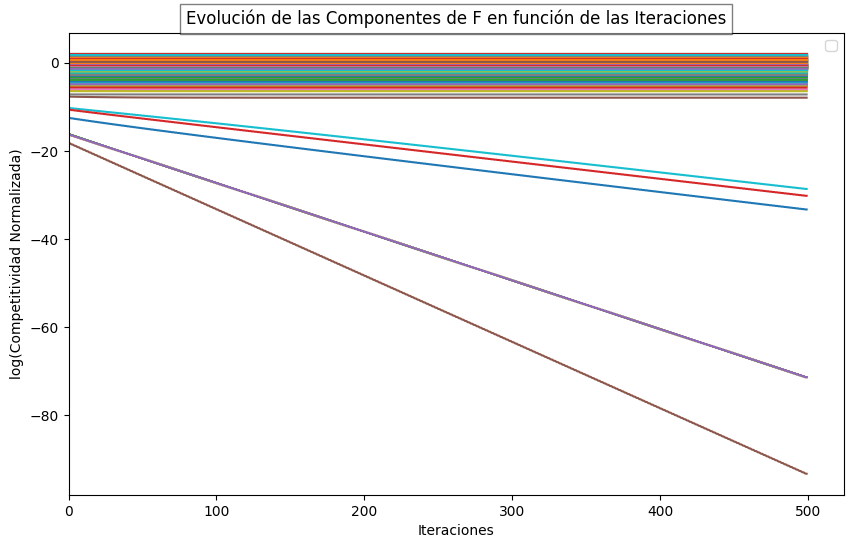

In [58]:
# Representar la evolución de las componentes de F en función de las iteraciones
plt.figure(figsize=(10, 6))
logaritmo = 1 # Cambiar a 0 para escala lineal
if logaritmo == 1: # Representación en escala logarítmica.
    for j in range(c):
        plt.plot(range(n), np.log(F_valores[:, j]))
    plt.ylabel('log(Competitividad Normalizada)')
else:
    for j in range(c):
        plt.plot(range(n), F_valores[:, j])
    plt.ylabel('Competitividad Normalizada')
plt.xlim(left=0)
plt.xlabel('Iteraciones')
plt.title('Evolución de las Componentes de F en función de las Iteraciones', bbox=dict(facecolor="white", alpha=0.5))
plt.legend()
plt.show()

Representación de la red compleja.

In [59]:
# Ordenar los valores de F y Q

# Crear un DataFrame para asociar las filas de M con los valores y etiquetas de F
F_dataframe = pd.DataFrame({'Country': M.index, 'F': F})
# Ordenar el DataFrame por el valor de F en orden descendente
F_ordenado = F_dataframe.sort_values(by='F', ascending=False).reset_index(drop=True)

# Crear un DataFrame para asociar las columnas de M con los valores de Q
Q_dataframe = pd.DataFrame({'Product': M.columns, 'Q': Q})
# Ordenar el DataFrame por el valor de Q en orden descendente
Q_ordenado = Q_dataframe.sort_values(by='Q', ascending=False).reset_index(drop=True)

print("Valores de F ordenados:")
print(F_ordenado)
print("Valores de Q ordenados:")
print(Q_ordenado)

Valores de F ordenados:
     Country             F
0        156  7.942792e+00
1        276  7.648521e+00
2        380  6.805677e+00
3        344  6.788764e+00
4        251  5.470754e+00
..       ...           ...
221      368  3.494810e-15
222      434  1.019315e-31
223      226  1.019315e-31
224      148  1.019315e-31
225      500  3.055146e-41

[226 rows x 2 columns]
Valores de Q ordenados:
     Product             Q
0       2913  1.708258e+01
1       7111  1.191999e+01
2       4007  1.079154e+01
3       2919  1.025900e+01
4       2906  9.094999e+00
...      ...           ...
1211    2709  6.855837e-31
1212    2505  6.473850e-40
1213    0904  6.473850e-40
1214    2517  6.473850e-40
1215    4014  6.473850e-40

[1216 rows x 2 columns]


In [60]:
# Extraer los elementos de M correspondientes a TOPc y TOPp
TOPc = F_ordenado.head(10)['Country'].tolist()  
TOPp = Q_ordenado.head(10)['Product'].tolist()

# Crear un nuevo DataFrame con los elementos de M correspondientes a TOPc y TOPp
M_top = M.loc[TOPc, TOPp]
M_top = M_top.fillna(0)  # Reemplazar NaN por 0 en el DataFrame resultante
print(M_top)

k    2913  7111  4007  2919  2906  2812  7002  5113  8444  5005
i                                                              
156   1.0   0.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0
276   1.0   1.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0   0.0
380   0.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0
344   0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0
251   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0
392   1.0   1.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0
490   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   1.0   0.0
757   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0   1.0
616   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0
724   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0


In [61]:
# Crea un grafo no dirigido
G = nx.Graph()

# Nombres de los 10 primeros países
countries = [str(x) for x in list(M_top.index[:])]
# Nombres de los 10 primeros productos
products = list(M_top.columns[:])

print(countries)
print(products)

['156', '276', '380', '344', '251', '392', '490', '757', '616', '724']
['2913', '7111', '4007', '2919', '2906', '2812', '7002', '5113', '8444', '5005']


In [62]:
# Pasar de códigos a nombres de países.
# Leer el archivo country_codes_V202501 y crear un diccionario para el mapeo
country_codes = {}
with open('country_codes_V202501.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        country_codes[row[0]] = row[1]
# Reemplazar los códigos por los nombres.
# Sustituir cada elemento de countries por el valor de la segunda columna evitando países vacíos
countries = [country_codes.get(country, country) for country in countries]

print(countries)

['China', 'Germany', 'Italy', 'Hong Kong', 'France', 'Japan', 'Taiwan', 'Switzerland', 'Poland', 'Spain']


In [63]:
# Añade los nodos (países y códigos) al grafo
for country in countries:
    G.add_node(country)
for product in products:
    G.add_node(product)

# Map country names to their corresponding numeric codes in M_top
country_code_mapping = {country_codes.get(str(code), str(code)): code for code in M_top.index}
mapped_countries = [country_code_mapping[country] for country in countries if country in country_code_mapping]

# Añade las aristas al grafo basado en la matriz de adyacencia
for i, country_code in enumerate(mapped_countries):
    for j, product in enumerate(products):
        if M_top.loc[country_code, product] == 1:  # Use .loc for label-based indexing
            G.add_edge(countries[i], product)  # Use the original country name for the graph

# Colores para los nodos
node_colors = ['#88fff1'] * len(countries) + ['#FF9999'] * len(products)

# Tamaño de los nodos
node_sizes = [F[countries.index(node)] * 80 if node in countries else Q[products.index(node)] * 1500 for node in G.nodes()]

# Posicionamiento de los nodos con mayor separación vertical
pos = {}
x_offset = -1  # Offset para la columna de países
y_spacing = 1.5  # Espaciado vertical entre nodos

# Posicionar los nodos de countries con mayor espaciado
for idx, country in enumerate(countries):
    pos[country] = (x_offset, -idx * (y_spacing + 10))

x_offset = 2  # Offset para la columna de productos

# Posicionar los nodos de products
for idx, product in enumerate(products):
    pos[product] = (x_offset, -idx * (y_spacing + 10))

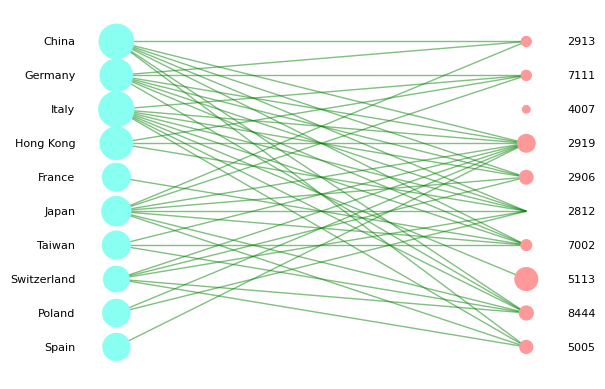

In [64]:
# Dibuja el grafo
# Posicionamiento de los nodos con menor separación horizontal
pos = {}
x_offset_countries = 0
x_offset_products = 0.7  # Reduce este valor para acercar los conjuntos

# Posicionar los nodos de countries
for idx, country in enumerate(countries):
    pos[country] = (x_offset_countries, -idx * (y_spacing + 10))

# Posicionar los nodos de products
for idx, product in enumerate(products):
    pos[product] = (x_offset_products, -idx * (y_spacing + 10))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='green', alpha=0.5)
# Dibujar etiquetas a los lados de los nodos
for node, (x, y) in pos.items():
    if node in countries:
        plt.text(x - 0.07, y, node, fontsize=8, ha='right', va='center')
    else:
        plt.text(x + 0.07, y, node, fontsize=8, ha='left', va='center')

# Ajustar los límites del gráfico
plt.axis('off')
plt.show()